# Importing Libraires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
from sklearn.preprocessing import RobustScaler , OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_curve , roc_auc_score , confusion_matrix , classification_report , f1_score , balanced_accuracy_score 
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import pickle

import warnings
warnings.filterwarnings(action="ignore")
plt.rcParams["figure.figsize"] = (12,8)

# Importing DatasetGridSearchCV

In [2]:
data = sns.load_dataset("titanic")
df = data.copy()
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Deleting blank spaces in the columns and capitalize them

In [3]:
df.columns = df.columns.str.strip()
df.rename(columns = lambda x : str(x).capitalize() , inplace = True)

# Droping duplicated columns

In [4]:
df.drop(columns = ["Embarked" , "Class"] , inplace = True)

# Using threshold method inside the dropna function

In [5]:
df.dropna(axis = 1 , thresh=df.shape[0]*0.70 , inplace=True)

# Converting True, False to Yes and No

In [6]:
df["Alone"] = df["Alone"].map({False : "No" , True : "Yes"})
df["Adult_male"] = df["Adult_male"].map({False : "No" , True : "Yes"})

# Checking the null values and visualize it with heatmap

In [7]:
df.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age            177
Sibsp            0
Parch            0
Fare             0
Who              0
Adult_male       0
Embark_town      2
Alive            0
Alone            0
dtype: int64

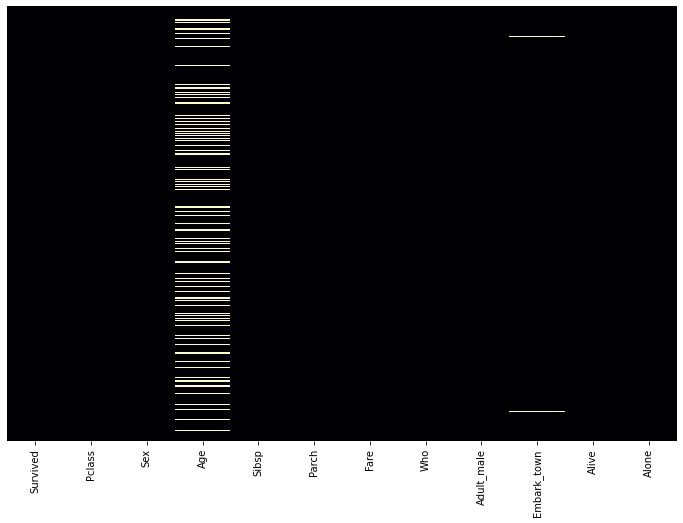

In [8]:
sns.heatmap(data = df.isnull() , cbar = False , cmap = "magma" , yticklabels=False)
plt.show()

# Droping duplicates 

In [9]:
print(f"Before there are {df.duplicated().sum()} in the dataset")
df.drop_duplicates(inplace = True , ignore_index=True)
print(f"After there are {df.duplicated().sum()} in the dataset")

Before there are 111 in the dataset
After there are 0 in the dataset


# Spliting Dataset to X and y

In [10]:
X = df.drop(columns = "Survived")
y = df["Survived"]

# Visualization for our predicted variable(dependent) and checked if the values of the outcome are balanced or not

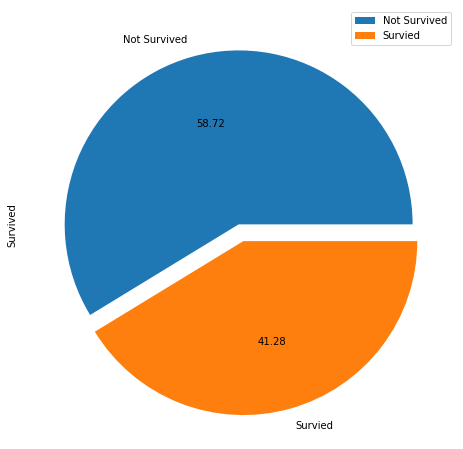

In [11]:
y.value_counts().plot(kind = "pie" , autopct = "%.2f" , explode = [0.0 , 0.1] , labels = ["Not Survived" , "Survied"])
plt.legend(loc = "best")
plt.show()

# Spliting DataSet to train and test

In [12]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42 , stratify=y)

# I have grouped all types of variables as list for pipeline

In [13]:
numeric = ["Age" , "Fare"]
categoric = ["Sex" , "Embark_town" , "Who" , "Alive" , "Alone" , "Adult_male"]
binary_ordinal = ["Pclass" , "Sibsp" , "Parch"]

# Creating pipelines for each types of variable

In [14]:
pipe_numeric = make_pipeline((SimpleImputer(missing_values=np.nan , strategy="median")) , (RobustScaler()))
pipe_category = make_pipeline((SimpleImputer(missing_values=np.nan , strategy="most_frequent")) , (OneHotEncoder(handle_unknown="ignore")))
pipe_binary = make_pipeline((SimpleImputer(missing_values=np.nan , strategy="most_frequent")))

# Applying pipelines to the dateset with the help of the make_column_tranformer

In [15]:
transformer = make_column_transformer((pipe_numeric , numeric),
                                       (pipe_category ,categoric),
                                       (pipe_binary , binary_ordinal))

# Automate score, metrics, cross validation, confussion matrix, roc_curve with the help of the functions

In [16]:
def score_func(model_name) : 
    train_score = model_name.score(X_train , y_train)
    test_score = model_name.score(X_test , y_test)
    
    print("The train score is {:.2f}".format(train_score))
    print("The test score is {:.2f}".format(test_score))

In [17]:
def metrics_func(model_name) : 
    roc = roc_auc_score(y_test , y_pred)
    f1 = f1_score(y_test , y_pred)
    gini = (roc*2) - 1
    balance = balanced_accuracy_score(y_test , y_pred)
    
    print("The roc auc score is {:.2f}".format(roc))
    print("The f1 score is {:.2f}".format(f1))
    print("The gini score is {:.2f}".format(gini))
    print("The balance score is {:.2f}".format(balance))

In [18]:
def cross_func(model_name) : 
    cr = cross_val_score(estimator=model_name  , X = X_train , y = y_train , scoring="accuracy" , cv = 10 , n_jobs=-1)
    
    max_score = np.argmax(cr)
    min_score = np.argmin(cr)
    average_score = np.mean(cr)
    
    print("The maxsimum score for this model can be {:.2f}".format(cr[max_score]))
    print("The minumum score for this model can be {:.2f}".format(cr[min_score]))
    print("The mean of the cross validation is {:.2f}".format(average_score))

In [19]:
def roc_curve_func(model_name) : 
    fpr , tpr, _ = roc_curve(y_true = y_test , y_score = model_name.predict_proba(X_test)[:,1])
    plt.plot(fpr , tpr , label = "Our Model" , color = "green")
    plt.plot([0,1],[0,1] , label = "Random Model" , color = "magenta")
    plt.title("Roc Curve" , fontsize = 16)
    plt.ylabel("True Positive Rate" , fontsize = 16)
    plt.xlabel("False Positive Rate" , fontsize = 16)
    plt.legend(loc = "best")
    plt.show()

In [20]:
def confussion_function(model_name) : 
    cm = confusion_matrix(y_test , y_pred)
    sns.heatmap(data = cm , cbar = False , cmap = plt.cm.Blues , yticklabels=False , xticklabels=False , annot=True , fmt=".5g")
    plt.title("Confussion Matrix" , fontsize = 16 , c = "white")
    plt.ylabel("Ground Truth" , fontsize = 16 , c = "white")
    plt.xlabel("Predictions" , fontsize = 16 , c = "white")
    plt.show()

In [21]:
def confussion_matrix_for_train(model_name) :
    y_pred = model_name.predict(X_train)
    cm = confusion_matrix(y_train , y_pred)
    sns.heatmap(data = cm , cmap = plt.cm.Blues , annot = True , fmt = ".5g" , yticklabels=False , xticklabels=False , cbar = False)
    plt.title("Confussion Matrix" , fontsize = 16 , c = "white")
    plt.ylabel("Ground Truth" , fontsize = 16 , c = "white")
    plt.xlabel("Predictions" , fontsize = 16 , c = "white")
    plt.show()

# Logistic Regression

In [22]:
model_log = make_pipeline(transformer , SequentialFeatureSelector(estimator=LogisticRegression() , cv = 5 , n_jobs=-1) ,
                                        LogisticRegression())
model_log.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                        

# Parametrs for Logistic Regression

In [23]:
params = {
         "logisticregression__C" : [0,1,2,3],
         "logisticregression__tol" : [0.0001 , 0.001 , 0.01 , 0.1,1]}

# Creating hyperparametr_tuning with GridSearch

In [24]:
hyper_model_best = GridSearchCV(estimator=model_log , param_grid=params , scoring="accuracy" , n_jobs=-1 , cv = 10)
hyper_model_best.fit(X_train , y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                          

# Creating model with best_estimator

In [25]:
hyper_model = hyper_model_best.best_estimator_
hyper_model.fit(X_train , y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                        

# Train and Test score for Logistic Regression

In [26]:
score_func(model_name = hyper_model)

The train score is 1.00
The test score is 1.00


# Classification Report for Logistic Regression

In [27]:
y_pred = hyper_model.predict(X_test)

In [28]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00        64

    accuracy                           1.00       156
   macro avg       1.00      1.00      1.00       156
weighted avg       1.00      1.00      1.00       156



# Metrics for Logistic Regression

In [29]:
metrics_func(model_name=hyper_model)

The roc auc score is 1.00
The f1 score is 1.00
The gini score is 1.00
The balance score is 1.00


# Cross validation for Logistic Regression

In [30]:
cross_func(model_name=hyper_model)

The maxsimum score for this model can be 1.00
The minumum score for this model can be 1.00
The mean of the cross validation is 1.00


# Confussion Matrix for Logistic Regression

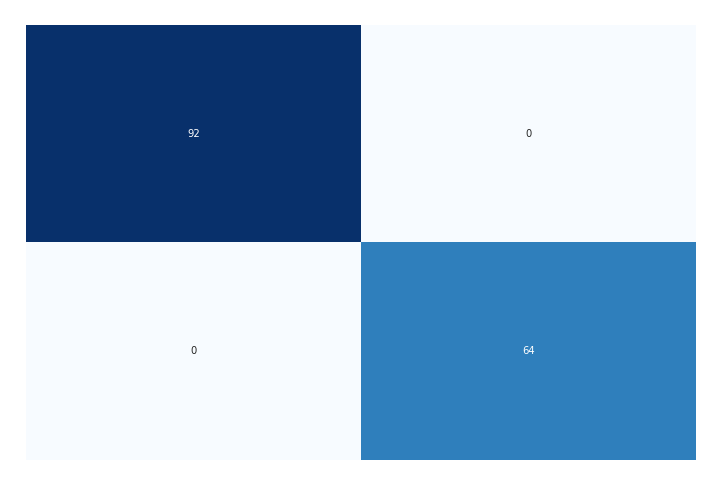

In [31]:
confussion_function(model_name= hyper_model)

# Confussion Matrix for train data to evaluate the performance of train data

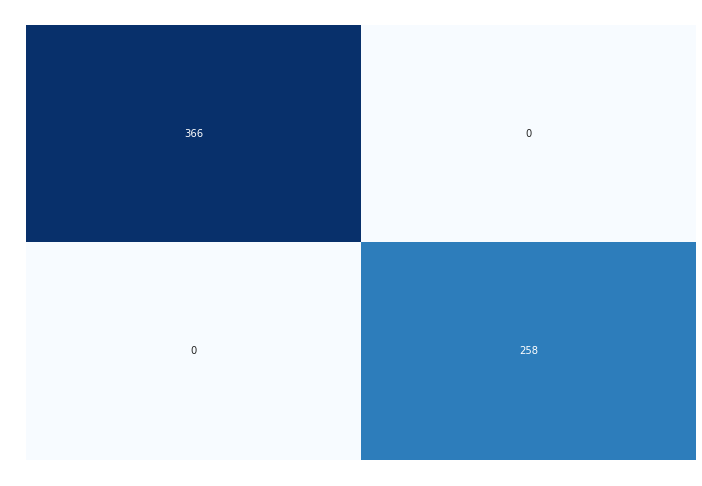

In [32]:
confussion_matrix_for_train(model_name=hyper_model)

# Roc Curve for Logistic Regression

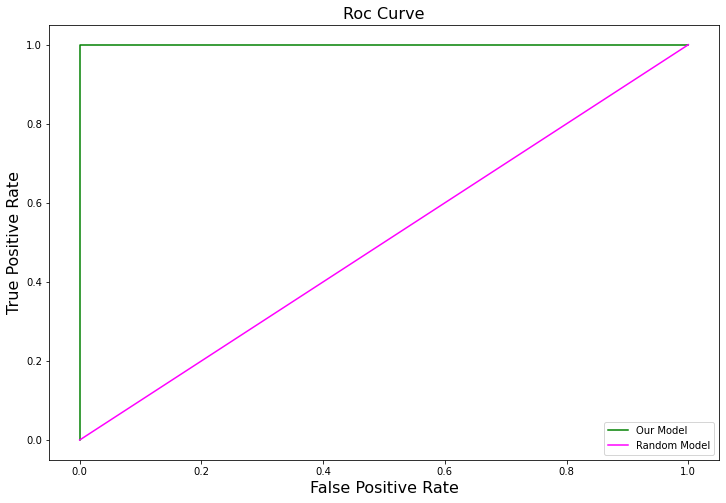

In [33]:
roc_curve_func(model_name=hyper_model)

# Saved our model for creating the stremlit application

In [34]:
file_name = "titanic_project"
pickle.dump(model_log , open(file_name , "wb"))

# Saved our X_test data for the predictions in streamlit

In [35]:
X_test.to_csv("titanic_X_test" , index=False)